In [20]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
#This is shit check how to import well
sys.path.insert(1, '/home/gende/DAS-Unsupervised-Noise-Filtering/Code/utilities')
import cwt , clusters
import matplotlib.colors as mcolors
import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn.cluster import KMeans
import os

In [2]:
transform = torch.load("../Data/synthetic-DAS/train-syntheticDAS/CWT-edDAS/transform0000_window1.pt")
features = np.array(transform)
features = np.reshape(features, (features.shape[0] * features.shape[1], -1))
print(features.shape)

(1536000, 63)


In [3]:

transform_dir = ("../Data/synthetic-DAS/train-syntheticDAS/CWT-edDAS")


files = os.listdir(transform_dir)
files.sort()
files=files[:100]


nfiles = len(files)
print(files[-1])
sample = torch.load(transform_dir + '/' + files[-1])
print(sample.shape)

n_features = sample.shape[2]
sps = 50
samplingRate = 50
secondsPerWindowOffset = sample.shape[1]
nChannels = sample.shape[0]
nSamples = secondsPerWindowOffset * int(sps / samplingRate)
nSamples_subsampled = nSamples //2
print(nSamples_subsampled)
"""
trainingData = np.empty((nChannels, nSamples_subsampled * nfiles, n_features), dtype=np.float64)
print(nfiles)

dir = '../Data/synthetic-DAS/train-syntheticDAS/ClusteringResults'

for index, file in enumerate(files):
  file = transform_dir + '/' + file
  trainingData[:,(index * nSamples_subsampled):((index + 1) * nSamples_subsampled),:] = np.array(torch.load(file))[:,::2, :]
print("training data shape before reshape", trainingData.shape)
# Clustering
trainingData = np.reshape(trainingData, (nChannels * nSamples_subsampled * nfiles, -1))
"""

transform0049_window2.pt
torch.Size([512, 3000, 63])
1500


'\ntrainingData = np.empty((nChannels, nSamples_subsampled * nfiles, n_features), dtype=np.float64)\nprint(nfiles)\n\ndir = \'../Data/synthetic-DAS/train-syntheticDAS/ClusteringResults\'\n\nfor index, file in enumerate(files):\n  file = transform_dir + \'/\' + file\n  trainingData[:,(index * nSamples_subsampled):((index + 1) * nSamples_subsampled),:] = np.array(torch.load(file))[:,::2, :]\nprint("training data shape before reshape", trainingData.shape)\n# Clustering\ntrainingData = np.reshape(trainingData, (nChannels * nSamples_subsampled * nfiles, -1))\n'

In [4]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim, input_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, encoding_dim)
        )
        ## decoder ##
        self.decoder =   self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32,input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        if(not torch.is_tensor(x)):
            x = torch.tensor(x, dtype=torch.float32)
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        # pass x into encoder
        out = F.relu(self.encoder(x))
        # pass out into decoder
        out = self.decoder(out)
        
        return out
    
    def encode(self, x ):
        if(not torch.is_tensor(x)):
            x = torch.tensor(x, dtype=torch.float32)
        return self.encoder(x)

# initialize the NN
encoding_dim = 10



In [ ]:
model = Autoencoder(encoding_dim, features.shape[1])
batch_size = 1000
batched_data = torch.tensor(np.reshape(trainingData, (batch_size, -1, features.shape[1])))
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 200
losses = np.zeros(n_epochs)

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in batched_data:
        images = torch.tensor(data, dtype=torch.float32)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(batched_data)
    losses[epoch-1] = train_loss
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

In [ ]:
plt.plot(losses)
plt.title("Training Loss ")

torch.Size([512, 3000, 63])


NameError: name 'model' is not defined

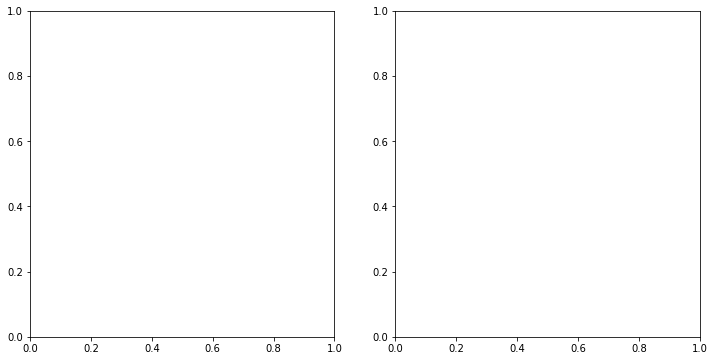

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(12,6))
print(transform.shape)
reconstruction = model(transform[0])
img1 = ax1.imshow(transform[0].T, origin='lower', interpolation='nearest', cmap='rainbow', aspect='auto')
img2 = ax2.imshow(reconstruction.detach().numpy().T, origin='lower', interpolation='nearest', cmap='rainbow', aspect='auto')
fig.colorbar(img1, ax=ax1)
fig.colorbar(img2 , ax =ax2)

In [6]:
trained_model = Autoencoder(encoding_dim, features.shape[1])

state_dict = torch.load('syntheticAE.nn')
trained_model.load_state_dict(state_dict)

<All keys matched successfully>

In [32]:
transform_dir = ("../Data/synthetic-DAS/train-syntheticDAS/CWT-edDAS")
files = os.listdir(transform_dir)

clustering_files = 4

nSamples = 3000

features = np.empty((nChannels, nSamples *clustering_files, n_features))
print(features.shape)
for i in range(clustering_files):
    features[:,nSamples*i:nSamples*i + nSamples,:] = np.array(torch.load(transform_dir +'/' + files[i]))
                    
features = np.reshape(features, (nChannels* nSamples * clustering_files, -1))
print(features.shape)

(512, 12000, 63)
(6144000, 63)


In [33]:
encoded_features =trained_model.encode(features)

In [34]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(encoded_features.detach().numpy())

KMeans(n_clusters=3)

In [35]:
labels = kmeans.labels_
labels.shape
labels = np.reshape(labels, (nChannels, nSamples*2,-1))

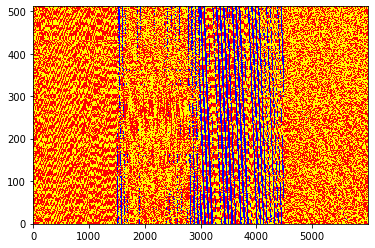

In [38]:
cmap = mcolors.ListedColormap(['yellow', 'green', 'red', 'blue'])
plt.imshow(labels[:,:,1], origin='lower', interpolation='nearest', cmap=cmap, aspect='auto')